# Semantic Segmentation `DataPipe`

author: Thomas Capelle (tcapelle@wandb.com)

We are using the Cambridge-driving Labeled Video Database or CamVid. It contains a collection of videos with object class semantic labels, complete with metadata. The database provides ground truth labels that associate each pixel with one of 32 semantic classes. 

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torchdata.datapipes.iter as pipes
from torch.utils.data.datapipes.utils.decoder import imagehandler
from torchdata.datapipes.iter import FileOpener, IterableWrapper, Mapper, RoutedDecoder, TarArchiveLoader

Let's grab CamVid from the fastai S3 bucket:

In [35]:
camvid_url = "https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz"
camvid_path = "camvid"

if not Path(camvid_path).exists():
    !wget {camvid_url}
    !tar -xf camvid.tgz    # x: extract, f: file

the decompressed folder structure looks like this

```bash
$tree camvid
camvid
├── codes.txt
├── images
│   ├── 0001TP_006690.png
│   ├── 0001TP_006720.png
│   ├── 0001TP_006750.png
│   .﻿.﻿.
├── labels 
│   ├── 0001TP_006690_P.png
│   ├── 0001TP_006720_P.png
│   ├── 0001TP_006750_P.png
│.  .﻿.﻿.
└── valid.txt
```

In [36]:
camvid_path = Path("camvid")
list(camvid_path.iterdir())

[Path('camvid/valid.txt'),
 Path('camvid/codes.txt'),
 Path('camvid/images'),
 Path('camvid/labels')]

We have the images in `camvid/images` and the labels in `camvid/labels`

### Utils

Define some helper functions to show images, borrowed from `fastai`

In [37]:
# from fastai
def _fig_bounds(x):
    r = x//32
    return min(5, max(1,r))

def show_image(im, ax=None, figsize=None, title=None, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    # Handle pytorch axis order
    if hasattrs(im, ('data','cpu','permute')):
        im = im.data.cpu()
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    # Handle 1-channel images
    if im.shape[-1]==1: im=im[...,0]
    if figsize is None: figsize = (_fig_bounds(im.shape[0]), _fig_bounds(im.shape[1]))
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax

def show_images(ims, nrows=1, ncols=None, titles=None, **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`."
    if ncols is None: ncols = int(math.ceil(len(ims)/nrows))
    if titles is None: titles = [None]*len(ims)
    axs = plt.subplots(nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip(ims, titles, axs): show_image(im, ax=ax, title=t)

## With a Labelling function

 First, we list all .png files inside the images folder:

In [38]:
image_files = list((camvid_path/"images").iterdir())
image_files[0:5]

[Path('camvid/images/Seq05VD_f04290.png'),
 Path('camvid/images/0001TP_009630.png'),
 Path('camvid/images/0006R0_f02940.png'),
 Path('camvid/images/0016E5_05250.png'),
 Path('camvid/images/0016E5_08017.png')]

In [39]:
def label_func(fname):
    "returns fname, label_fname"
    fname = Path(fname)
    name = fname.with_suffix("").name + "_P.png"# remove suffix
    return fname, fname.parent.parent/f"labels/{name}"

the segmentation masks (labels) have the same filename with the suffix `_P`

In [40]:
label_func(image_files[0])

(Path('camvid/images/Seq05VD_f04290.png'),
 Path('camvid/labels/Seq05VD_f04290_P.png'))

### `FileLister`
> Iterate through the images filenames

In [41]:
dp = pipes.FileLister([camvid_path/"images"], masks="*.png")

#sanity check
next(iter(dp))

'camvid/images/0001TP_006690.png'

### Mapper
> we can apply the `label_func` to each file

In [42]:
dp = pipes.Mapper(dp, label_func)
next(iter(dp))

(Path('camvid/images/0001TP_006690.png'),
 Path('camvid/labels/0001TP_006690_P.png'))

we can open the images using PIL now

In [43]:
def PIL_open(data):
    return Image.open(data[0]), Image.open(data[1])

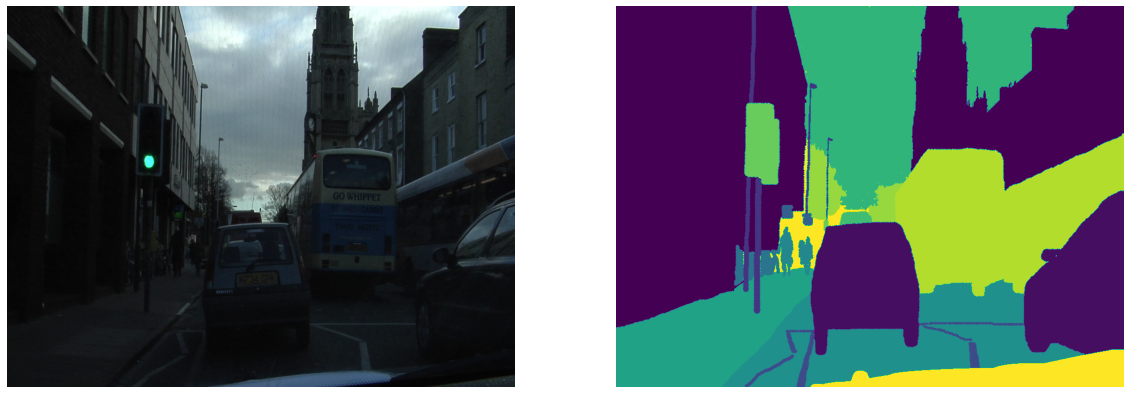

In [44]:
dp = pipes.Mapper(dp, PIL_open)

# show the tuple
show_images(next(iter(dp)), figsize=(20,10))

## Zip to `DataPipes` together

> Putting two pipelines in parallel and merge them together with `Zipper` and map the `Image.open`

In [48]:
images = pipes.FileLister([camvid_path/"images"], masks="*.png").map(Image.open)
labels = pipes.FileLister([camvid_path/"labels"], masks="*.png").map(Image.open)

> Note: The `FileLister` class by default sorts the returned files by name so they match

we merge both `DataPipes` using `Zipper`. We can also shuffle the results and batch!

In [50]:
ds = pipes.Zipper(images, labels).shuffle().batch(3)

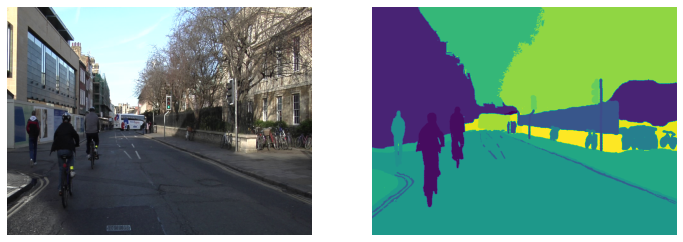

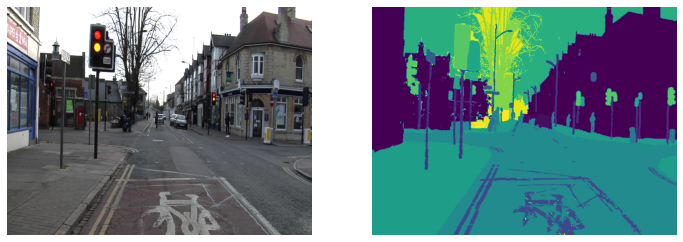

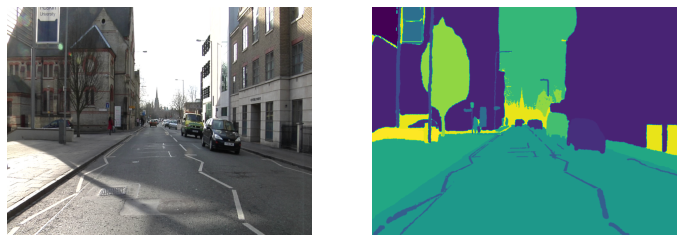

In [51]:
batch = next(iter(ds))
for im, mk in batch:
    show_images([im, mk], figsize=(12,6))

## Directly reading an archive `.tar` file

> Reading the tar files as a data stream

In [52]:
camvid_itertable = pipes.IterableWrapper(["camvid.tgz"])

In [53]:
tgz = FileOpener(camvid_itertable, mode="b")
next(iter(tgz))

('camvid.tgz', StreamWrapper<<_io.BufferedReader name='camvid.tgz'>>)

In [54]:
files = tgz.load_from_tar()
next(iter(files))

('camvid.tgz/camvid/codes.txt',
 StreamWrapper<<ExFileObject name='camvid.tgz'>>)

In [73]:
images = pipes.Filter(files, filter_fn=lambda tup: Path(tup[0]).parent.name == "images")
labels = pipes.Filter(files, filter_fn=lambda tup: Path(tup[0]).parent.name == "labels")

The `StreamWrapper` class returns a filename and a stream

In [74]:
next(iter(images))

('camvid.tgz/camvid/images/0016E5_00750.png',
 StreamWrapper<<ExFileObject name='camvid.tgz'>>)

In [75]:
images = pipes.RoutedDecoder(images, imagehandler("pil"))
labels = pipes.RoutedDecoder(labels, imagehandler("pill"))  # on mode pil-L

In [76]:
next(iter(images))

('camvid.tgz/camvid/images/0016E5_00750.png',
 <PIL.Image.Image image mode=RGB size=960x720 at 0x7FB5DD4D99A0>)

but we do't get files in order, so we have to match them with `IterKeyZipper`, based on the filename

In [77]:
def get_image_id(data):
    path, _ = data
    return Path(path).name.split(".")[0]

def get_label_id(data):
    path, _ = data
    return Path(path).name.split("_P")[0]

In [86]:
dp = pipes.IterKeyZipper(images, 
                         labels, 
                         get_image_id, 
                         get_label_id).map(lambda tup: (tup[0][1], tup[1][1]))

this is extremely slow...

In [87]:
next(iter(dp))

(<PIL.Image.Image image mode=RGB size=960x720 at 0x7FB5DDE4BF40>,
 <PIL.Image.Image image mode=L size=960x720 at 0x7FB5DDC04070>)

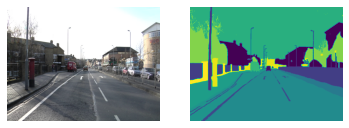

In [88]:
show_images(next(iter(dp)))